In [10]:
def bcctcoreClassifier (asyMeasDict, colScarMeasDict):
    
    feat0=asyMeasDict['pLBC']
    
    feat1=asyMeasDict['pBCE']
    
    
    try:
        feat2=colScarMeasDict['cChi2b']
    except Exception:
        print ('NO cChi2b')
        feat2=0
   
    
    features = [feat0, feat1, feat2]
    
    return scorecardPrediction(features)
    
def scorecardPrediction(features) :
    classes = ["UNKNOWN", "EXCELLENT", "GOOD", "FAIR", "POOR"]
    prediction = -1
    points = 0.0
    if (features[0]<0.0174):
        points = 0
    elif (features[0]<0.1012):
        points = 0.1538
    elif (features[0]<0.1707):
        points = 0.4379
    else:
        points = 0.5767

    if (features[1]<0.0184):
        points += 0
    elif (features[1]<0.3684):
        points += 0.0636
    elif (features[1]<0.9219):
        points += 0.1938
    else :
        points += 0.2128

    if (features[2]<0.0140):
        points += 0
    elif (features[2]<0.0267):
        points += 0.0299
    elif (features[2]<0.6881):
        points += 0.0642
    else:
        points += 0.0727

    if (points < 0.1738):
        prediction = 1
    elif (points<0.3720):
        prediction = 2
    elif (points<0.7002):
        prediction = 3
    else:
        prediction = 4
    return prediction, classes[prediction]


### use RiskSLIM on aesthetic data only with columns chosen by old scorecard

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sbc import SBC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from scorecard import Scorecard


# columns thresholds
pLBC_thresholds = [0.0174, 0.1012, 0.1707]
pBCE_thresholds = [0.0184, 0.3684, 0.9219]
cXb2_thresholds = [0.0140, 0.0267, 0.6881]
thresholds = {
    'pLBC Value': pLBC_thresholds,
    'pBCE Value': pBCE_thresholds,
    'cX2b Value': cXb2_thresholds,
    'sbcol1': [0.5],
    'sbcol2': [0.5]
}

# prediction thresholds
prediction_thresholds = [0.1738, 0.3720, 0.7002]


# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

# get train and test sets
train_X, test_X, train_y, test_y = train_test_split(aesthetic_evaluation_X, aesthetic_evaluation_y, test_size=0.25, random_state=42)

# do SBC on the train set
sbc = SBC()
sbc_train_X, sbc_train_y = sbc.reduction(train_X, train_y, 4)


# get encoded version of the data with differential coding
def disc_diff_coding(X, thresholds, categorical=[]):
    encoded_X = []
    for col in X.columns:
        if col not in thresholds.keys():
            continue  # skip columns not in thresholds
        if col in categorical:
            bin = pd.Categorical(X[col], categories=thresholds[col]).codes
            num_bins = len(thresholds[col])
        else:
            X_col_float = X[col].astype(float)
            bin = np.digitize(X_col_float, thresholds[col]) # gets bin number of each row
            num_bins = len(thresholds[col]) + 1
        
        bin_df = pd.DataFrame(0, index=X.index, columns=[f'feat{col}-bin{i}' for i in range(1, num_bins)])
        for i in range(1, num_bins):
            bin_df[f'feat{col}-bin{i}'] = (bin >= i).astype(int)
        
        encoded_X.append(bin_df)

    # concatenate all encoded columns
    encoded_X = pd.concat(encoded_X, axis=1)

    return encoded_X



# encode the data
encoded_X = disc_diff_coding(sbc_train_X, thresholds)

# add the target variable as the first column, and substitute 0 by -1
encoded_X.insert(0, 'target', sbc_train_y.replace({0: -1}))

# to csv
encoded_X.to_csv('datasets/riskslim/aesthetic_old_scorecard.csv', index=False)

In [12]:
''' 
+---------------------------------------------+-------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |
| =========================================== | ================= | ========= |
| featpLBC Value-bin3                         |          3 points |   + ..... |
| featpLBC Value-bin2                         |          1 points |   + ..... |
| featpBCE Value-bin3                         |          0 points |   + ..... |
| featpBCE Value-bin2                         |          0 points |   + ..... |
| featcX2b Value-bin1                         |          0 points |   + ..... |
| featpBCE Value-bin1                         |          0 points |   + ..... |
| featcX2b Value-bin2                         |          0 points |   + ..... |
| featcX2b Value-bin3                         |          0 points |   + ..... |
| featpLBC Value-bin1                         |         -1 points |   + ..... |
| featsbcol2-bin1                             |         -1 points |   + ..... |
| featsbcol1-bin1                             |         -2 points |   + ..... |
| =========================================== | ================= | ========= |
| ADD POINTS FROM ROWS 1 to 11                |             SCORE |   = ..... |
+---------------------------------------------+-------------------+-----------+
{'L0_max': 11,
 'L0_min': 0,
 'c0_value': 1e-06,
 'callback_time': 0.002474069595336914,
 'coef_set': +---------------------+-------+------+------------+-----------+-----+
|    variable_name    | vtype | sign |     lb     |     ub    |  c0 |
+---------------------+-------+------+------------+-----------+-----+
|     (Intercept)     |   C   |  0   |   -50.0    |    50.0   | 0.0 |
| featpLBC Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpLBC Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpLBC Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featpBCE Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin1 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin2 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
| featcX2b Value-bin3 |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featsbcol1-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
|   featsbcol2-bin1   |   C   |  0   | -1000000.0 | 1000000.0 | nan |
+---------------------+-------+------+------------+-----------+-----+,
 'data_time': 0.0002448558807373047,
 'loss_value': 0.29084659844626914,
 'nodes_processed': 0,
 'objective_value': 0.2908575984462691,
 'optimality_gap': 0.0,
 'run_time': 0.006818056106567383,
 'solution': array([ 0.03108287, -1.23667316,  1.55110331,  3.06293898, -0.13022257,
        0.10859546,  0.74391516,  0.01040377, -0.19982142, -0.98230896,
       -2.02358663, -1.93094134]),
 'solver_time': 0.004343986511230469,
 'w_pos': 1.0}
 '''

" \n+---------------------------------------------+-------------------+-----------+\n| Pr(Y = +1) = 1.0/(1.0 + exp(-(0 + score))   |                   |           |\n| =========================================== | ================= | ========= |\n| featpLBC Value-bin3                         |          3 points |   + ..... |\n| featpLBC Value-bin2                         |          1 points |   + ..... |\n| featpBCE Value-bin3                         |          0 points |   + ..... |\n| featpBCE Value-bin2                         |          0 points |   + ..... |\n| featcX2b Value-bin1                         |          0 points |   + ..... |\n| featpBCE Value-bin1                         |          0 points |   + ..... |\n| featcX2b Value-bin2                         |          0 points |   + ..... |\n| featcX2b Value-bin3                         |          0 points |   + ..... |\n| featpLBC Value-bin1                         |         -1 points |   + ..... |\n| featsbcol2-bin1       

In [13]:
def riskslim_points(features, points_list, intercept):    
    total_points = intercept
    
    for i in range(len(features)):
        # just works for 1ook encoding
        if features[i] == 1:
            total_points += points_list[i]

    return total_points

def evaluate_riskslim_model(points_list, sbc, sbc_X, y, intercept):
    predictions = []
    
    for i in range(sbc_X.shape[0]):
        features = sbc_X.iloc[i].values
        points = riskslim_points(features, points_list, intercept)
        predictions.append(points)

        if points >= 0:
            predictions[i] = 1
        else:
            predictions[i] = 0
    
    # convert predictions to ordinal
    predictions = pd.Series(predictions)  
    predictions = sbc.classif(predictions, K=4)

    # apply mapping to integer labels
    y = sbc.apply_mapping(y, mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'})
    
    
    accuracy = accuracy_score(y, predictions)
    balanced_accuracy = balanced_accuracy_score(y, predictions)
    precision = precision_score(y, predictions, average='weighted', zero_division=0)
    recall = recall_score(y, predictions, average='weighted')
    f1 = f1_score(y, predictions, average='weighted')
    mse = mean_squared_error(y, predictions)
    logistic_loss = np.mean(np.log(1 + np.exp(-predictions * y)))
    print(f'accuracy: {accuracy}')
    print(f'balance accuracy: {balanced_accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f1 score: {f1}')
    print(f'mean squared error: {mse}')
    print(f'logistic loss: {logistic_loss}')
    
     # confusion matrix
    cm = confusion_matrix(y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(predictions), yticklabels=np.unique(predictions))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for idx, acc in enumerate(per_class_accuracy):
        print(f"accuracy for class {np.unique(y)[idx]}: {acc:.3f}")

    # convert predictions to ordinal
    predictions = pd.Series(predictions)  
    predictions = sbc.classif(predictions, K=4)

    # apply mapping to integer labels
    y = sbc.apply_mapping(y, mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'})
    
    
    accuracy = accuracy_score(y, predictions)
    balanced_accuracy = balanced_accuracy_score(y, predictions)
    precision = precision_score(y, predictions, average='weighted', zero_division=0)
    recall = recall_score(y, predictions, average='weighted')
    f1 = f1_score(y, predictions, average='weighted')
    mse = mean_squared_error(y, predictions)
    logistic_loss = np.mean(np.log(1 + np.exp(-predictions * y)))
    print(f'accuracy: {accuracy}')
    print(f'balanced accuracy: {balanced_accuracy}')
    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'f1 score: {f1}')
    print(f'mean squared error: {mse}')
    print(f'logistic loss: {logistic_loss}')
    
     # confusion matrix
    cm = confusion_matrix(y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(predictions), yticklabels=np.unique(predictions))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for idx, acc in enumerate(per_class_accuracy):
        print(f"accuracy for class {np.unique(y)[idx]}: {acc:.3f}")


accuracy: 0.07465618860510806
balance accuracy: 0.11179226475279107
precision: 0.15144147427748492
recall: 0.07465618860510806
f1 score: 0.0862538514391231
mean squared error: 4.216110019646365
logistic loss: 0.060884703698171665


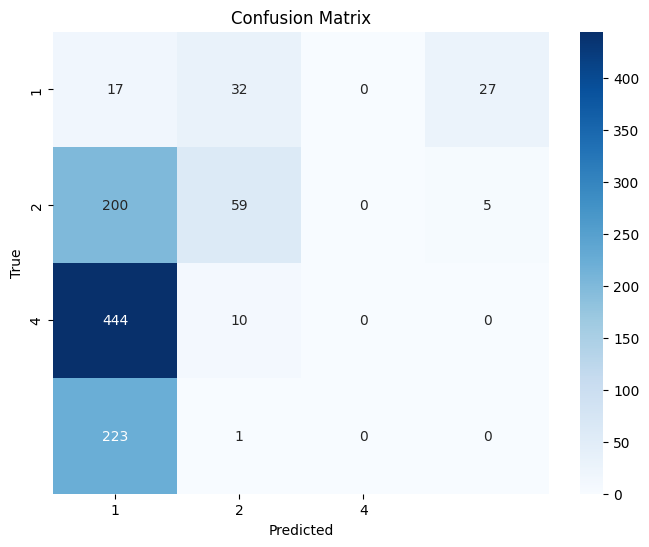

accuracy for class 1: 0.224
accuracy for class 2: 0.223
accuracy for class 3: 0.000
accuracy for class 4: 0.000


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (340,) + inhomogeneous part.

In [14]:
points_list = [ 0.03108287, -1.23667316,  1.55110331,  3.06293898, -0.13022257,
        0.10859546,  0.74391516,  0.01040377, -0.19982142, -0.98230896,
       -2.02358663, -1.93094134]
intercept = points_list[0] # the first element is the intercept
points_list = points_list[1:] 

encoded_X = encoded_X.drop(columns=['target']) 

# evaluate the model
evaluate_riskslim_model(points_list, SBC(), encoded_X, train_y, intercept)

### ensemble of scorecards --> add column to aesthetic data of total number of points assigned by old scorecard and give that data to my scorecard

In [4]:
def old_scorecard_points(features) :    
    points = 0.0

    # 'pLBC Value'
    if (features[0]<0.0174):
        points = 0
    elif (features[0]<0.1012):
        points = 0.1538
    elif (features[0]<0.1707):
        points = 0.4379
    else:
        points = 0.5767

    # 'pBCE Value'
    if (features[1]<0.0184):
        points += 0
    elif (features[1]<0.3684):
        points += 0.0636
    elif (features[1]<0.9219):
        points += 0.1938
    else :
        points += 0.2128
    
    # 'cX2b Value' 
    if (features[2]<0.0140):
        points += 0
    elif (features[2]<0.0267):
        points += 0.0299
    elif (features[2]<0.6881):
        points += 0.0642
    else:
        points += 0.0727
    
    return points

Column indices for old scorecard: [0, 1, 2]


/var/folders/wk/c98ddbnx3pd7fpdy174bcjmr0000gn/T/ipykernel_79332/2473790061.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aesthetic_evaluation_X.loc[i, 'points'] = points



Objective Evaluation accuracy: 0.597

Evaluating the model on the test set...
test predictions:  [1 1 0 ... 0 0 0]
     True Value  Prediction
0             3           3
1             3           3
2             1           2
3             2           2
4             2           2
..          ...         ...
335           2           2
336           2           2
337           1           2
338           1           2
339           1           1

[340 rows x 2 columns]
accuracy:  0.5676470588235294
precision:  0.5835586709931497
recall:  0.5676470588235294
f1 score:  0.555152424993263
balanced accuracy:  0.4842518426668558
logistic loss:  0.05856012447127919
mse:  0.4852941176470588
number of far off predictions:  14
number of features:  27
number of non-zero weights:  16
model size (non-zero weights / all weights):  0.5925925925925926


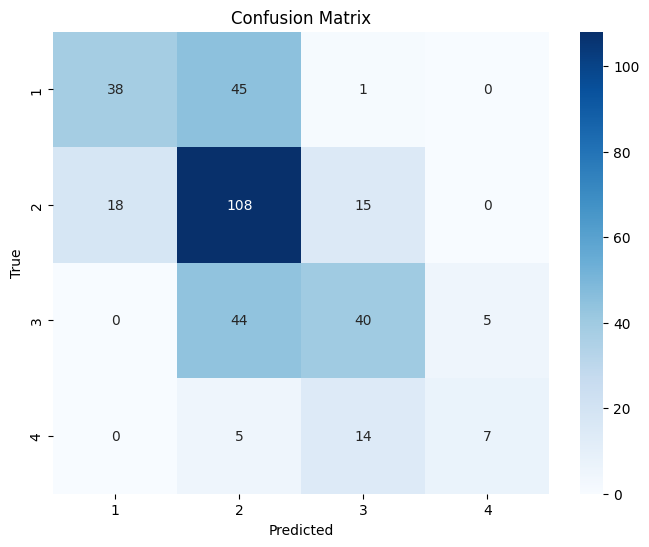

accuracy for class 1: 0.452
accuracy for class 2: 0.766
accuracy for class 3: 0.449
accuracy for class 4: 0.269

Evaluating the model on the train set...
accuracy on train set:  0.5972495088408645
precision on train set:  0.6062749493479842
recall on train set:  0.5972495088408645
f1 score on train set:  0.5826004963467931
balanced accuracy on train set:  0.5270116981856925
logistic loss on train set:  0.04621599063842464
mse on train set:  0.48035363457760316

Scorecard table:
               Feature    Weight
0  featpLBC Value-bin1 -0.732847
1  featpLBC Value-bin2 -0.404925
2  featpLBC Value-bin3  0.416823
3  featpLBC Value-bin4  0.650467
4  featpLBC Value-bin5  0.000000
               Feature    Weight
5  featpBCE Value-bin1 -0.409655
6  featpBCE Value-bin2  0.000000
7  featpBCE Value-bin3  0.000000
8  featpBCE Value-bin4  0.517508
9  featpBCE Value-bin5  0.000000
                Feature    Weight
10  featcX2b Value-bin1  0.000000
11  featcX2b Value-bin2  0.000000
12  featcX2b Value-

In [6]:
from scorecard import Scorecard
import pandas as pd
from sklearn.metrics import accuracy_score

# load data
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_objective_evaluation = aesthetic_evaluation_data['Objective Evaluation']
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data[['pLBC Value', 'pBCE Value', 'cX2b Value', 'pUNR Value']]
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

# get indices of columns used by the old scorecard
columns = ['pLBC Value', 'pBCE Value', 'cX2b Value']
column_indices = [aesthetic_evaluation_X.columns.get_loc(col) for col in columns]
print(f'Column indices for old scorecard: {column_indices}')

# add column 'points' to X, calculated by old_scorecard_points
for i in range(aesthetic_evaluation_X.shape[0]):
    features = aesthetic_evaluation_X.iloc[i].values
    points = old_scorecard_points(features)
    aesthetic_evaluation_X.loc[i, 'points'] = points
    
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                               thresholds_method='CAIM',
                               encoding_method='1_OUT_OF_K',
                               model_method='ML',
                               params= {},
                               use_sbc=True,
                               K=4,
                               mapping = {4: 'Poor', 3: 'Fair', 2: 'Good', 1: 'Excellent'}
                               )

# see accuracy of 'Objective Evaluation' on test set
test = scorecard.test_X
test_objective = aesthetic_evaluation_objective_evaluation.loc[test.index]
objective_acc = accuracy_score(test_objective, scorecard.test_y)
print(f'\nObjective Evaluation accuracy: {objective_acc:.3f}')

scorecard.evaluate()

scorecard.show_scorecard()


Evaluating the model on the test set...
test predictions:  [1 0 0 ... 1 1 1]
     True Value  Prediction
0             2           2
1             2           2
2             4           3
3             3           2
4             3           3
..          ...         ...
335           3           2
336           3           3
337           4           3
338           4           3
339           4           4

[340 rows x 2 columns]
accuracy:  0.5470588235294118
precision:  0.561115379810095
recall:  0.5470588235294118
f1 score:  0.5433934289533039
balanced accuracy:  0.5120881091177529
logistic loss:  0.006787824218846791
mse:  0.4970588235294118
number of far off predictions:  16
number of features:  117
number of non-zero weights:  112
model size (non-zero weights / all weights):  0.9572649572649573


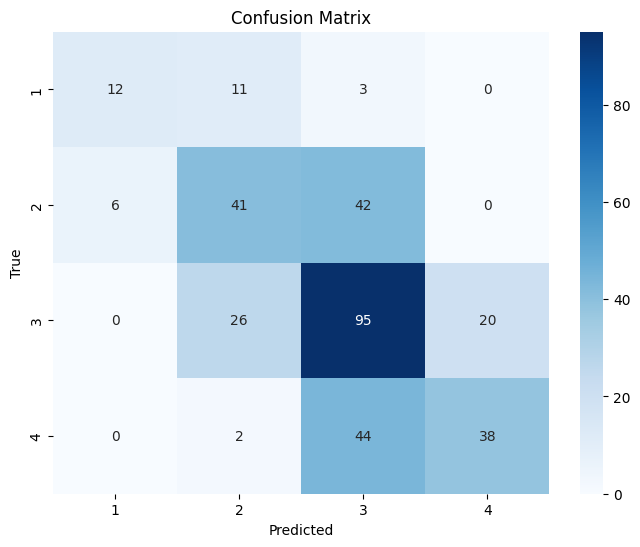

accuracy for class 1: 0.462
accuracy for class 2: 0.461
accuracy for class 3: 0.674
accuracy for class 4: 0.452

Evaluating the model on the train set...
accuracy on train set:  0.6365422396856582
precision on train set:  0.6403157492601877
recall on train set:  0.6365422396856582
f1 score on train set:  0.6292795905459942
balanced accuracy on train set:  0.6077799076310119
logistic loss on train set:  0.010498934535641798
mse on train set:  0.4204322200392927

Scorecard table:
                Feature    Weight
0    featBRA Value-bin1  0.099248
1    featBRA Value-bin2  0.090130
2    featBRA Value-bin3 -0.017997
3    featBRA Value-bin4  0.099202
4    featBRA Value-bin5 -0.270583
35  featpBRA Value-bin1  0.433304
36  featpBRA Value-bin2 -0.163658
37  featpBRA Value-bin3 -0.192433
38  featpBRA Value-bin4  0.193371
39  featpBRA Value-bin5 -0.270583
                Feature    Weight
5    featLBC Value-bin1  0.192637
6    featLBC Value-bin2  0.183332
7    featLBC Value-bin3 -0.115841
8    fe

In [ ]:
scorecard = Scorecard()
model, weights = scorecard.fit(aesthetic_evaluation_X, aesthetic_evaluation_y, [],
                                thresholds_method='CAIM',
                                encoding_method='1_OUT_OF_K',
                                model_method='MM',
                                params={'C': 8, 'class_weight': None},
                                use_sbc=True,
                                K=4,
                                mapping = {1: 'Poor', 2: 'Fair', 3: 'Good', 4: 'Excellent'}
                               )

scorecard.evaluate()

scorecard.show_scorecard()